In [2]:
import shap
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset

# Load datasets
df_true = pd.read_csv("C://Users//isaac//Desktop//FakeRealNews//True.csv")
df_fake = pd.read_csv("C://Users//isaac//Desktop//FakeRealNews//Fake.csv")

# Examine the shape of the dataframes
print("Shape of df_fake:", df_fake.shape)
print("Shape of df_true:", df_true.shape)

# Inspect the columns
print("\nColumns of df_fake:", df_fake.columns.values)
print("Columns of df_true:", df_true.columns.values)

# Check data types
print("\nData types of df_fake:\n", df_fake.dtypes)
print("\nData types of df_true:\n", df_true.dtypes)

# Investigate missing values
print("\nMissing values in df_fake:\n", df_fake.isnull().sum())
print("\nMissing values in df_true:\n", df_true.isnull().sum())

# Calculate descriptive statistics for numerical columns (text length)
print("\nAverage text length in df_fake:", df_fake['text'].str.len().mean())
print("Average text length in df_true:", df_true['text'].str.len().mean())

# Analyze subject distributions
print("\nSubject distribution in df_fake:\n", df_fake['subject'].value_counts())
print("\nSubject distribution in df_true:\n", df_true['subject'].value_counts())

# Analyze date ranges (basic check)
print("\nEarliest date in df_fake:", df_fake['date'].min())
print("Latest date in df_fake:", df_fake['date'].max())
print("\nEarliest date in df_true:", df_true['date'].min())
print("Latest date in df_true:", df_true['date'].max())

C:\Users\isaac\anaconda3\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


Shape of df_fake: (23481, 4)
Shape of df_true: (21417, 4)

Columns of df_fake: ['title' 'text' 'subject' 'date']
Columns of df_true: ['title' 'text' 'subject' 'date']

Data types of df_fake:
 title      object
text       object
subject    object
date       object
dtype: object

Data types of df_true:
 title      object
text       object
subject    object
date       object
dtype: object

Missing values in df_fake:
 title      0
text       0
subject    0
date       0
dtype: int64

Missing values in df_true:
 title      0
text       0
subject    0
date       0
dtype: int64

Average text length in df_fake: 2547.396235254035
Average text length in df_true: 2383.278517065882

Subject distribution in df_fake:
 News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

Subject distribution in df_true:
 politicsNews    11272
worldnews       10145
Name: subject, dtype: int64

Earlies

In [3]:
# Handle the invalid dates in df_fake
# Given the large number, dropping rows might introduce bias
# Drop rows with invalid dates

# Remove duplicated rows from df_fake_cleaned and keep the first occurrence
df_fake_cleaned = df_fake.drop_duplicates(keep='first')

# Remove duplicated rows from df_true and keep the first occurrence
df_true = df_true.drop_duplicates(keep='first')

# Remove rows with empty strings in the 'text' column from df_fake_cleaned
df_fake_cleaned = df_fake_cleaned[df_fake_cleaned['text'].str.strip() != '']

# Remove rows with empty strings in the 'text' column from df_true
df_true = df_true[df_true['text'].str.strip() != '']


# Re-check the date range and missing values
print("\nDate range analysis after cleaning:")
print("Earliest date in df_fake_cleaned:", df_fake_cleaned['date'].min())
print("Latest date in df_fake_cleaned:", df_fake_cleaned['date'].max())

print("\nNull values in 'date' column after cleaning:")
print("df_fake_cleaned:", df_fake_cleaned['date'].isnull().sum())
print("df_true:", df_true['date'].isnull().sum())
# Explore other potential issues
# Check for duplicated rows
print("\nNumber of duplicated rows in df_fake_cleaned:", df_fake_cleaned.duplicated().sum())
print("Number of duplicated rows in df_true:", df_true.duplicated().sum())

# Further analysis
# Example: Check for empty strings in 'text' columns
print("\nEmpty strings in 'text' column:")
print("df_fake_cleaned:", df_fake_cleaned['text'].str.strip().eq('').sum())
print("df_true:", df_true['text'].str.strip().eq('').sum())

# Examine the shape of the dataframes
print("\nShape of df_fake:", df_fake_cleaned.shape)
print("Shape of df_true:", df_true.shape)


Date range analysis after cleaning:
Earliest date in df_fake_cleaned: 14-Feb-18
Latest date in df_fake_cleaned: https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg

Null values in 'date' column after cleaning:
df_fake_cleaned: 0
df_true: 0

Number of duplicated rows in df_fake_cleaned: 0
Number of duplicated rows in df_true: 0

Empty strings in 'text' column:
df_fake_cleaned: 0
df_true: 0

Shape of df_fake: (22848, 4)
Shape of df_true: (21210, 4)


In [4]:
# Analyze subject distributions after cleaning df_fake
print("\nSubject distribution in df_fake_cleaned:\n", df_fake_cleaned['subject'].value_counts(normalize=True))
print("\nSubject distribution in df_true:\n", df_true['subject'].value_counts(normalize=True))


from collections import Counter

# Function to find top keywords
def find_top_keywords(df, top_n=10):
    all_words = []
    for text in df['text']:
      all_words.extend(text.lower().split())
    word_counts = Counter(all_words)
    return word_counts.most_common(top_n)


# Find top keywords in each dataset
top_keywords_fake = find_top_keywords(df_fake_cleaned)
top_keywords_true = find_top_keywords(df_true)

print("\nTop keywords in fake news:")
print(top_keywords_fake)

print("\nTop keywords in true news:")
print(top_keywords_true)


Subject distribution in df_fake_cleaned:
 News               0.396096
politics           0.281425
left-news          0.188594
Government News    0.065564
US_News            0.034270
Middle-east        0.034051
Name: subject, dtype: float64

Subject distribution in df_true:
 politicsNews    0.528949
worldnews       0.471051
Name: subject, dtype: float64

Top keywords in fake news:
[('the', 525499), ('to', 288545), ('of', 235142), ('and', 222323), ('a', 209585), ('in', 162835), ('that', 144891), ('s', 128330), ('is', 107714), ('for', 91063)]

Top keywords in true news:
[('the', 471986), ('to', 241454), ('of', 202253), ('a', 194234), ('and', 178653), ('in', 177291), ('on', 106376), ('that', 83948), ('for', 78206), ('said', 71167)]


In [5]:
df_fake_cleaned.to_csv('fake_cleaned.csv', index=False)  # Save to a new file
df_true.to_csv('true_cleaned.csv', index=False)  # Save to a new file

In [6]:
new_true_df = pd.read_csv("fake_cleaned.csv")
new_fake_df = pd.read_csv("true_cleaned.csv")

In [7]:
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords

# Download stopwords if not already present
try:
    stop_words = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))


# Add a label column: 1 for true news, 0 for fake news
new_true_df["label"] = 1
new_fake_df["label"] = 0

# Inspect the columns
print("\nColumns of df_fake:", new_fake_df.columns.values)
print("Columns of df_true:", new_true_df.columns.values)




Columns of df_fake: ['title' 'text' 'subject' 'date' 'label']
Columns of df_true: ['title' 'text' 'subject' 'date' 'label']


In [8]:
import re
# Combine the datasets
data = pd.concat([new_true_df, new_fake_df], ignore_index=True)

def clean_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'\[.*?\]', '', text)  # Remove brackets
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = " ".join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

# Apply function
#data["text"] = data["title"] + " " + data["text"]  # Combine title and text
data["text"] = data["text"].astype(str).apply(clean_text)

# Shuffle data
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

display(data.head())

,title,text,subject,date,label
0,JUDGE JEANINE PIRRO DECLARES WAR On Hillary…Le...,judge jeanine pirro rips crooked hillary collu...,politics,"Jul 26, 2016",1
1,WATCH: Giuliani’s BIG LIE At Trump Rally Is J...,former new york city mayor rudy giuliani recen...,News,"August 15, 2016",1
2,Republican House Speaker Ryan backs Trump afte...,washington reuters paul ryan top elected repub...,politicsNews,"June 2, 2016",0
3,Wikileaks: NSA Spied on UN Secretary-General a...,inversewikileaks released tonight new cache do...,Middle-east,"February 23, 2016",1
4,Freeing of hostages in Pakistan a 'positive si...,tampa fla reuters freeing kidnapped u canadian...,worldnews,"October 12, 2017",0


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=5, max_df=0.8)

# Fit and transform the text data
tfidf_matrix = tfidf_vectorizer.fit_transform(data['text'])

# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Concatenate the TF-IDF features with the original DataFrame
data = pd.concat([data, tfidf_df], axis=1)

display(data.head())

,title,text,subject,date,label,abadi,abandoned,abc,abc news,abe,...,youth,youtube,zealand,zero,zika,zimbabwe,zone,zones,zor,zuma
0,JUDGE JEANINE PIRRO DECLARES WAR On Hillary…Le...,judge jeanine pirro rips crooked hillary collu...,politics,"Jul 26, 2016",1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,WATCH: Giuliani’s BIG LIE At Trump Rally Is J...,former new york city mayor rudy giuliani recen...,News,"August 15, 2016",1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Republican House Speaker Ryan backs Trump afte...,washington reuters paul ryan top elected repub...,politicsNews,"June 2, 2016",0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Wikileaks: NSA Spied on UN Secretary-General a...,inversewikileaks released tonight new cache do...,Middle-east,"February 23, 2016",1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Freeing of hostages in Pakistan a 'positive si...,tampa fla reuters freeing kidnapped u canadian...,worldnews,"October 12, 2017",0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
from sklearn.model_selection import train_test_split

# Separate features (TF-IDF features) and target variable
X = data.drop(['title', 'text', 'subject', 'date', 'label'], axis=1)
y = data['label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

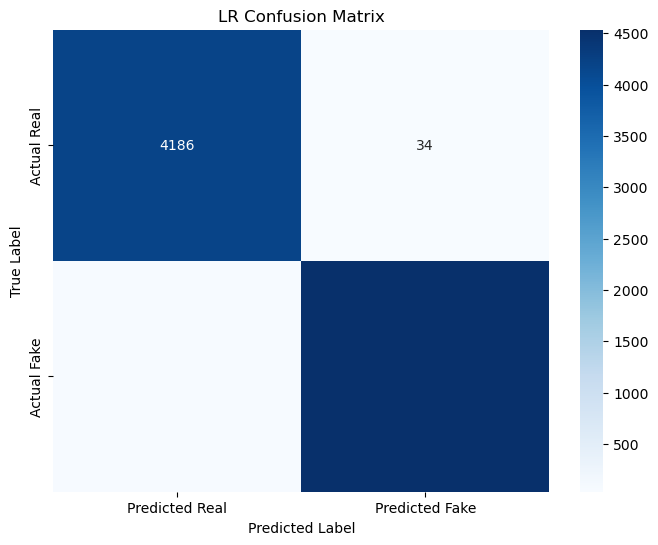

Accuracy: 0.9896
Precision: 0.9926
Recall: 0.9874
F1-score: 0.9900
AUC-ROC: 0.9897


In [11]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
logreg = LogisticRegression(max_iter=1000)

# Train the model
logreg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logreg.predict(X_test)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Real', 'Predicted Fake'],
            yticklabels=['Actual Real', 'Actual Fake'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('LR Confusion Matrix')
plt.show()

# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

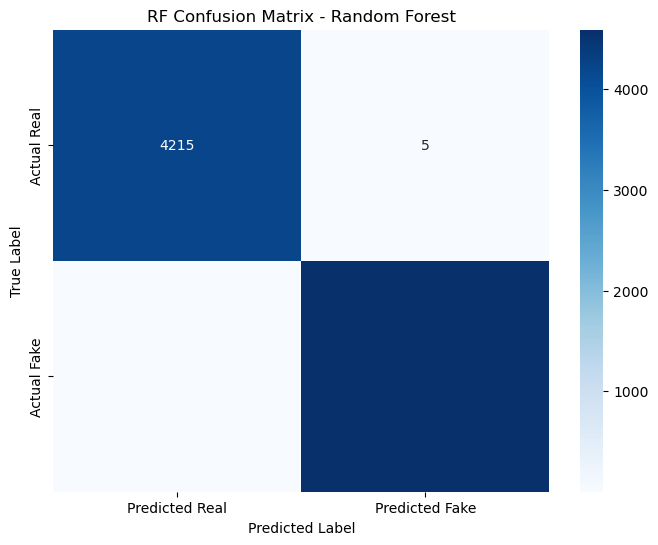

Accuracy: 0.9990
Precision: 0.9989
Recall: 0.9991
F1-score: 0.9990
AUC-ROC: 0.9990


In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf.predict(X_test)

# Calculate evaluation metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
auc_roc_rf = roc_auc_score(y_test, y_pred_rf)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Real', 'Predicted Fake'],
            yticklabels=['Actual Real', 'Actual Fake'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('RF Confusion Matrix - Random Forest')
plt.show()

# Print evaluation metrics
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1-score: {f1_rf:.4f}")
print(f"AUC-ROC: {auc_roc_rf:.4f}")

In [13]:
X_bert = data['text']  # Use the raw text data
y_bert = data['label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)  # Binary classification

# Tokenize the data
def tokenize_data(texts, labels, max_length=128):
    encodings = tokenizer(texts.tolist(), truncation=True, padding=True, max_length=max_length, return_tensors='pt')
    return TensorDataset(encodings['input_ids'], encodings['attention_mask'], torch.tensor(labels.tolist()))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


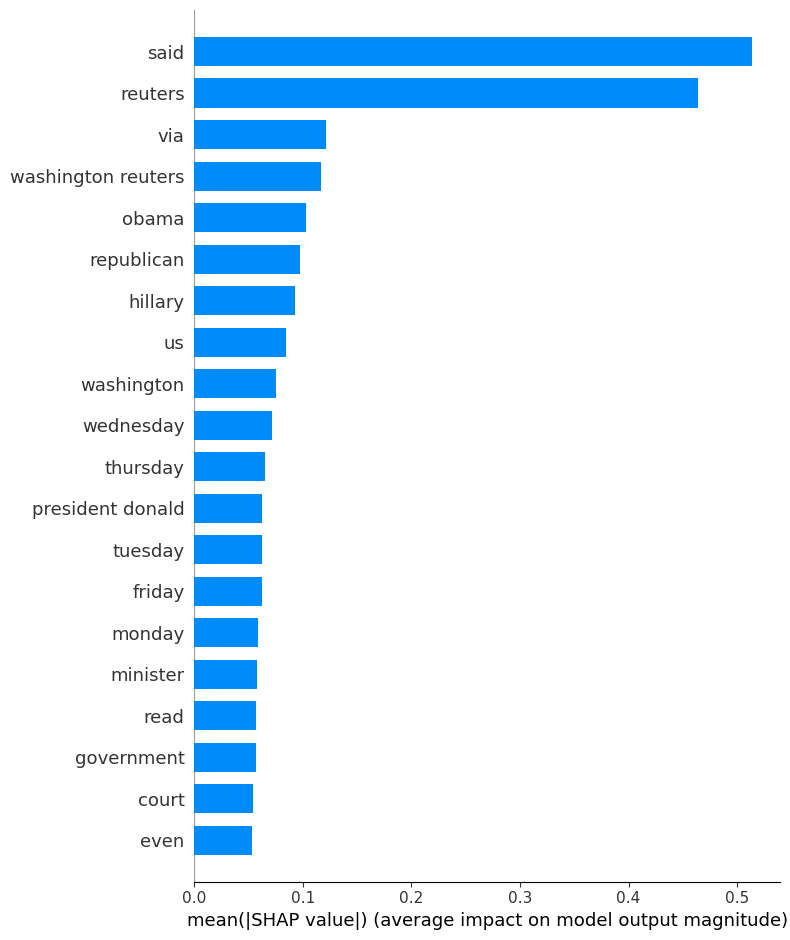

In [14]:
import shap
import matplotlib.pyplot as plt

# Initialize the explainer
explainer = shap.LinearExplainer(logreg, X_train)

# Compute SHAP values
shap_values = explainer.shap_values(X_test)

# Generate summary plot
plt.figure(figsize=(12, 8))  # Adjust figure size for better visualization
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.tight_layout()
plt.show()

<Figure size 800x600 with 0 Axes>

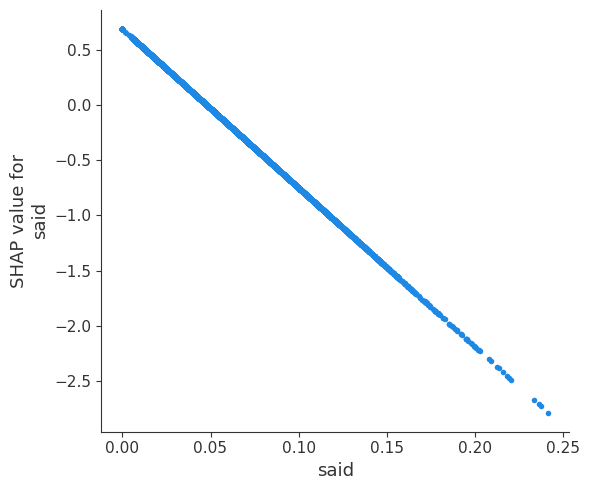

<Figure size 800x600 with 0 Axes>

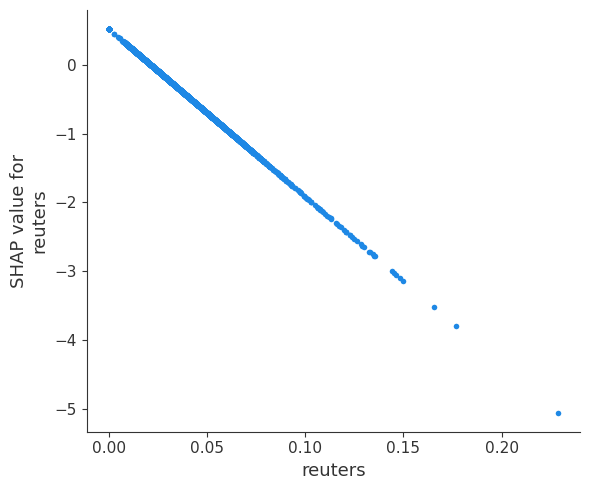

<Figure size 800x600 with 0 Axes>

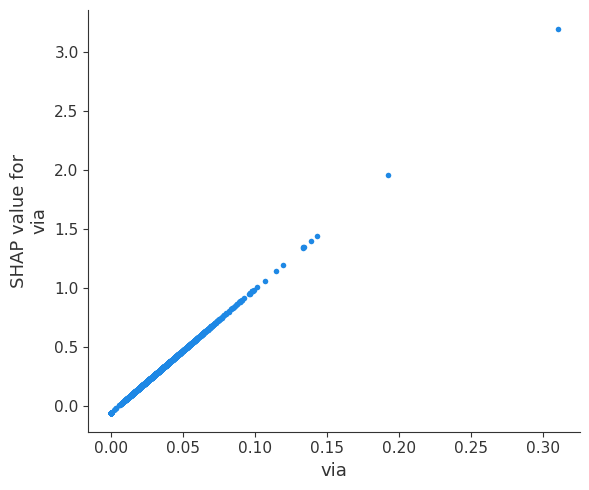

In [15]:
import matplotlib.pyplot as plt

top_features = ['said', 'reuters', 'via']

for feature in top_features:
    if feature in X_test.columns:
        plt.figure(figsize=(8, 6))  # Adjust figure size as needed
        shap.dependence_plot(feature, shap_values, X_test, interaction_index=None, show=False)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Feature '{feature}' not found in X_test")

# Downward Trend

When the trend of the scatter points in a SHAP dependence plot goes downwards, it means that as the value of the feature increases, its SHAP value generally decreases. This implies that higher values of the feature are associated with lower predictions, or in other words, the feature has a negative impact on the model's output as its value increases.

# Upward Trend

Conversely, when the trend goes upwards, it means that as the value of the feature increases, its SHAP value generally increases as well. This implies that higher values of the feature are associated with higher predictions, or in other words, the feature has a positive impact on the model's output as its value increases.

# Pushing the Prediction

When a feature has a positive SHAP value, it means that the presence or value of that feature for a specific instance is pushing the model's prediction higher than the baseline prediction. In other words, the feature is contributing to an increase in the predicted value compared to what the model would predict on average without considering that feature.

Conversely, when a feature has a negative SHAP value, it means that the presence or value of that feature is pushing the model's prediction lower than the baseline prediction. In other words, the feature is contributing to a decrease in the predicted value compared to what the model would predict on average without considering that feature.

<Figure size 1000x600 with 0 Axes>

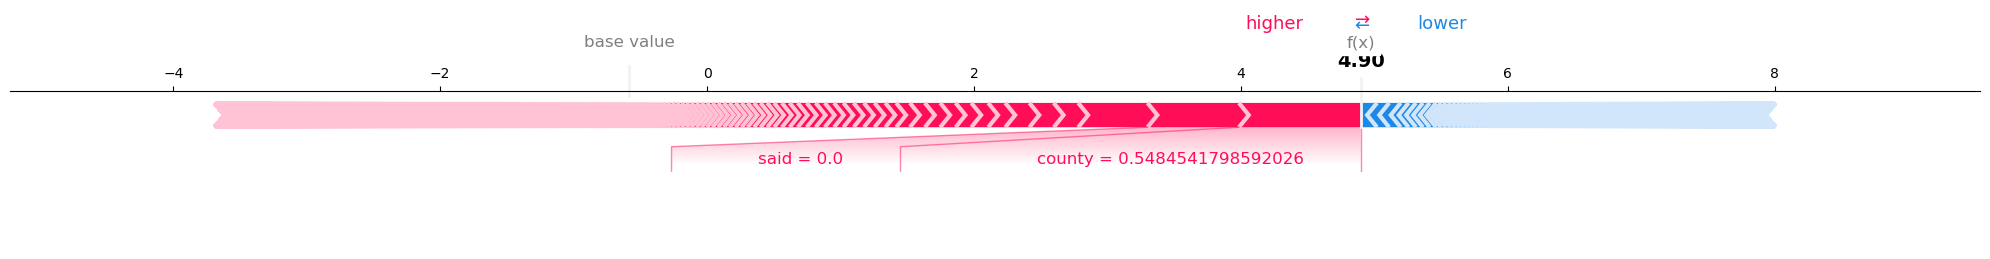

<Figure size 1000x600 with 0 Axes>

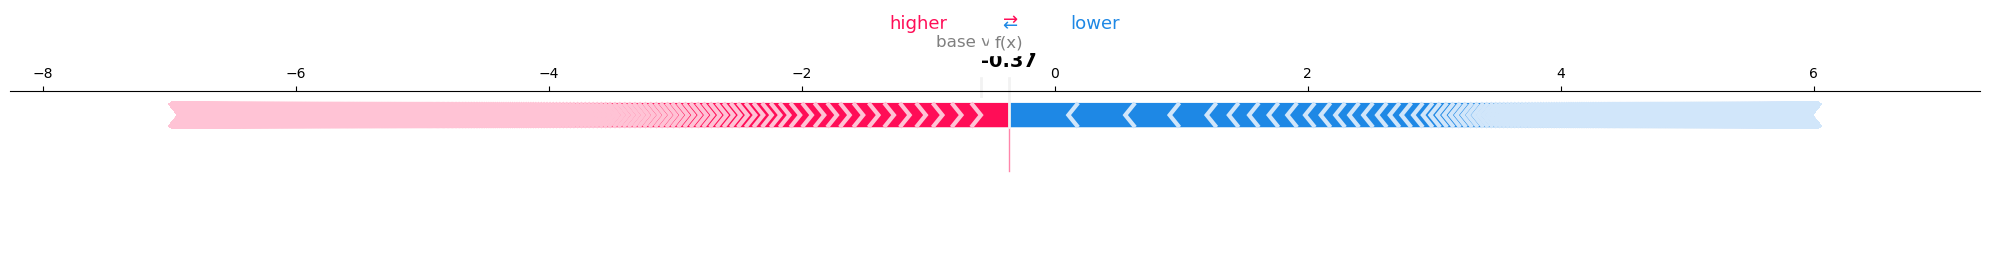

<Figure size 1000x600 with 0 Axes>

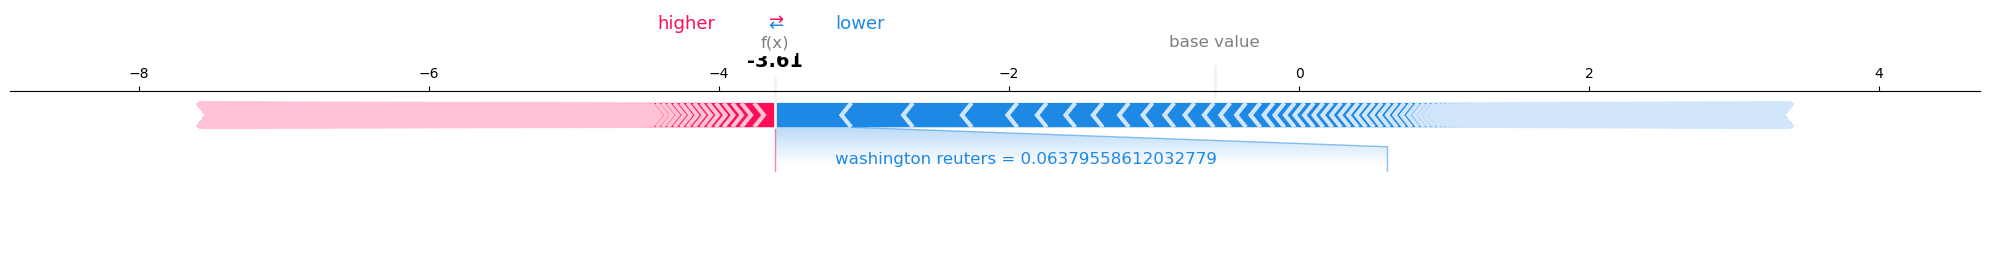

<Figure size 1000x600 with 0 Axes>

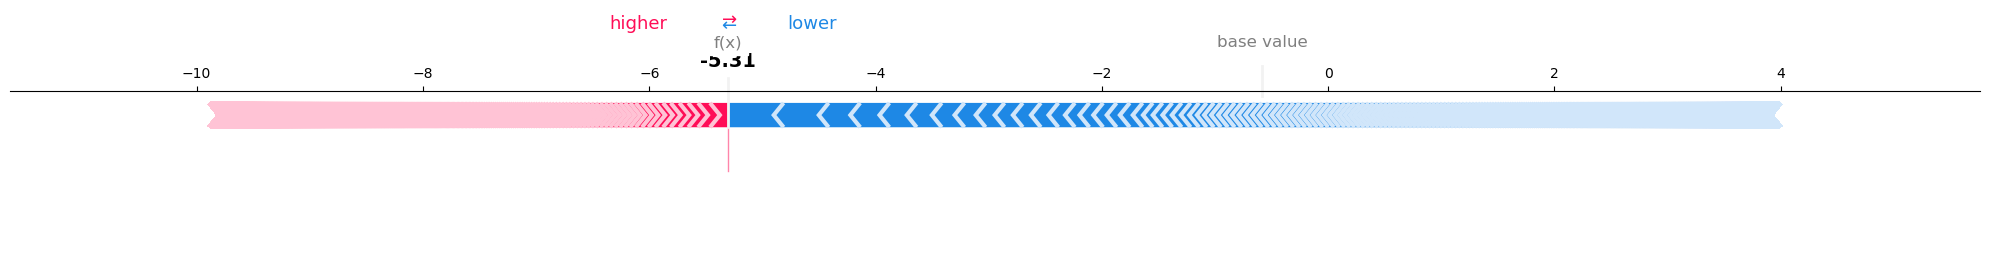

In [16]:
import matplotlib.pyplot as plt
# Select a few instances from the test set for force plots
instance_indices = [0, 1, 2, 3]  

for i in instance_indices:
    try:
        plt.figure(figsize=(10, 6))  # Adjust figure size as needed
        shap.force_plot(explainer.expected_value, shap_values[i,:], X_test.iloc[i,:], matplotlib=True, show=False)
        plt.tight_layout()
        plt.show()
    except IndexError:
        print(f"IndexError: Index {i} out of range for X_test")

SHAP Force Plots visualize how different features contribute to the model's decision for individual predictions.
The horizontal axis represents the model's decision boundary, where values greater than 0 indicate a prediction of "fake news" and values less than 0 suggest "real news".
